# CPE - TP ML 2024/25: Supervised Learning
## Classification of MNIST data
### Contents : Carole Lartizien


### Family Name and surname :

## - Import some usefull libraries

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pylab import *

from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import datasets
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

## - Define some usefull functions

In [3]:
#for sklearn version >0.22, use ConfusionMatrixDisplay
#Else, use the following function to plot confusion matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## - Import the MNIST dataset
### Deux méthodes, directement par fetch_openml ou telechargement des donnees puis ouverture avec loadmat

In [4]:
# Load data from https://www.openml.org/d/554
X, Y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)
# Attention, Y est un str par defaut, le convertir en int
Y=Y.astype(int)

(70000, 784)
(70000,)


In [4]:
# download MNIST dataset from https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat
from scipy.io import loadmat
mnist = loadmat("mnist-original.mat")
X= mnist["data"].T
Y= mnist["label"][0]


print(X.shape)
print(Y.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'mnist-original.mat'

### **Question** : À quoi correspond ici le '784' dans 'mnist_784' ?

## - Format the training and validation database

In [5]:
#Selection de 5000 points d'entrainements parmi les 60000 premiers exemples de MNIST
np.random.seed(seed=10)

ind_train=np.random.choice(np.arange(60000)+1, 5000, replace = False)

print(f"Nombres d'indices selectionnés : {ind_train.shape}")
print(f"Indice maximum : {max(ind_train)}")
print(f"indice minimum : {min(ind_train)}")

Xtrain=X[ind_train]
print(f"Nouvelle forme Xtrain : {Xtrain.shape}")

Ytrain=Y[ind_train]
print(f"Nouvelle forme Ytrain : {Ytrain.shape}")


sum_ = 0
print(f"Valeur max Ytrain : {max(Ytrain)}")
print(f"Valeur min Ytrain : {min(Ytrain)}")
for k in range(0, 10):
    print(f"Nombre d'images d'entrainement de label {k} : {(Ytrain == k).sum()}")
    sum_ += ((Ytrain == k).sum())
print(f"Nombre total d'images d'entrainement: {sum_}")

#Construction de la base de test : 10000 derniers exemples de MNIST
sum_ = 0
Xtest = X[60000:]
Ytest = Y[60000:]

for k in range(0, 10):
    print(f"Nombre d'images de test de label {k}: {(Ytest == k).sum()}")
    sum_ += ((Ytest == k).sum())
print(f"Nombre total d'images de test : {sum_}")

Nombres d'indices selectionnés : (5000,)
Indice maximum : 59994
indice minimum : 6
Nouvelle forme Xtrain : (5000, 784)
Nouvelle forme Ytrain : (5000,)
Valeur max Ytrain : 9
Valeur min Ytrain : 0
Nombre d'images d'entrainement de label 0 : 512
Nombre d'images d'entrainement de label 1 : 545
Nombre d'images d'entrainement de label 2 : 502
Nombre d'images d'entrainement de label 3 : 492
Nombre d'images d'entrainement de label 4 : 454
Nombre d'images d'entrainement de label 5 : 473
Nombre d'images d'entrainement de label 6 : 491
Nombre d'images d'entrainement de label 7 : 515
Nombre d'images d'entrainement de label 8 : 474
Nombre d'images d'entrainement de label 9 : 542
Nombre total d'images d'entrainement: 5000
Nombre d'images de test de label 0: 980
Nombre d'images de test de label 1: 1135
Nombre d'images de test de label 2: 1032
Nombre d'images de test de label 3: 1010
Nombre d'images de test de label 4: 982
Nombre d'images de test de label 5: 892
Nombre d'images de test de label 6: 958

#### Une autre manière de faire :

In [6]:
for k in range(0, 10):
    i=np.where(Ytest == k)
    print(f"Nombre d'images de test de label {k} : {size(i)}")

Nombre d'images de test de label 0 : 980
Nombre d'images de test de label 1 : 1135
Nombre d'images de test de label 2 : 1032
Nombre d'images de test de label 3 : 1010
Nombre d'images de test de label 4 : 982
Nombre d'images de test de label 5 : 892
Nombre d'images de test de label 6 : 958
Nombre d'images de test de label 7 : 1028
Nombre d'images de test de label 8 : 974
Nombre d'images de test de label 9 : 1009


In [6]:
print(X.shape, Y.shape)
print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

#Normalisation des données
sc = StandardScaler().fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

(70000, 784) (70000,)
(5000, 784) (5000,)
(10000, 784) (10000,)


#### Question : Pourquoi normalise-t-on les données ? Que fait cette normalisation ?

## - Visualisation des données

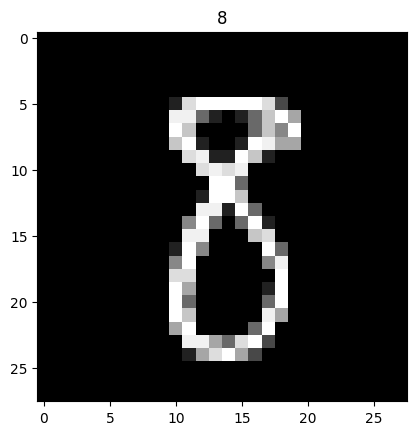

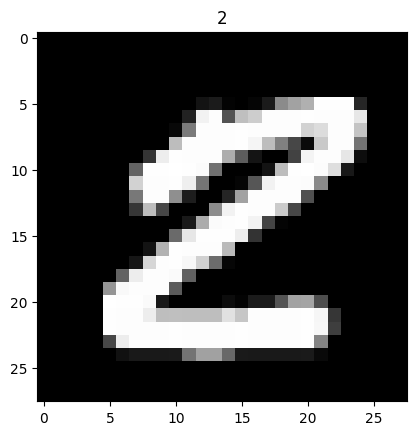

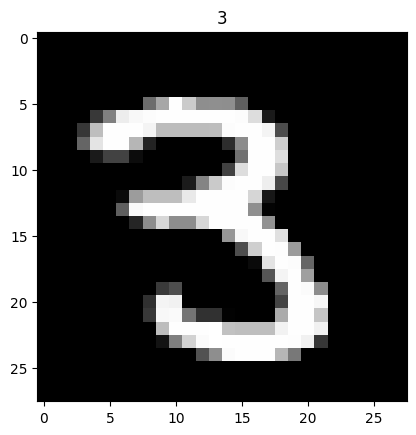

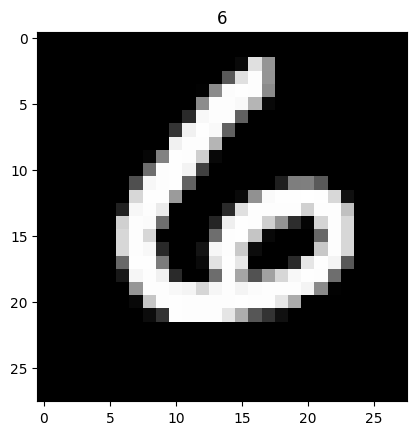

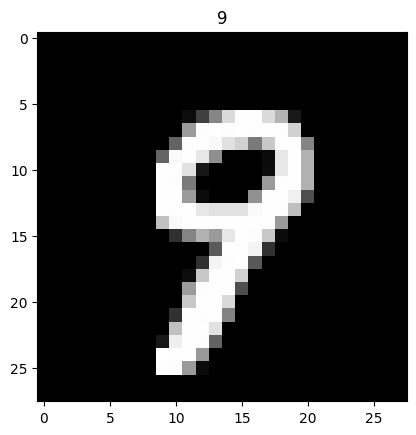

In [8]:
indices_img=[11450, 12585, 9520, 4587, 2351]

for ind_img in indices_img:
    im=X[ind_img]
    im = im.reshape((28,28))
    plt.figure()
    plt.imshow(im, cmap="Greys_r")
    plt.title(Y[ind_img])


## - Comparaison des performances de différents classifieurs

#### -  Entrainez et mesurez les performances des modèles suivants:
- SVM : linéaire et non -linéaire (RBF)
- Decision tree
- Random forest
- Régression logistique
.....

#### - Pour chaque modèle, lister et optimiser les hyperparamètres. Afficher les meilleures performances.

#### Astuce : utilisez la fonction GridSearchCV

--------------------
### SVM linéaire (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html):
--------------------
#### Lister les hyperparamètres ici:
- XX



In [9]:
from sklearn import svm
parameters = {'C':[0.1, 1, 10, 100]}
svc = svm.SVC(kernel="linear")
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [10]:
clf_SVML = GridSearchCV(svc, parameters, cv=5)
clf_SVML.fit(Xtrain, Ytrain)

GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10, 100]})

In [11]:
print(clf_SVML.best_score_) # correspond a acuracy = nombre_reponse_correcte/toute_les_reopnses
print(clf_SVML.best_estimator_.C)
clf_SVML.score(Xtest, Ytest)

0.8992000000000001
1


0.9094

In [12]:
Ytest_pred=clf_SVML.predict(Xtest)
print("Classification report for classifier %s:\n%s\n"
      % (clf_SVML, metrics.classification_report(Ytest, Ytest_pred)))

Classification report for classifier GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10, 100]}):
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.94      0.99      0.96      1135
           2       0.88      0.89      0.89      1032
           3       0.88      0.87      0.88      1010
           4       0.89      0.95      0.92       982
           5       0.88      0.86      0.87       892
           6       0.95      0.93      0.94       958
           7       0.91      0.90      0.91      1028
           8       0.91      0.85      0.88       974
           9       0.91      0.87      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000




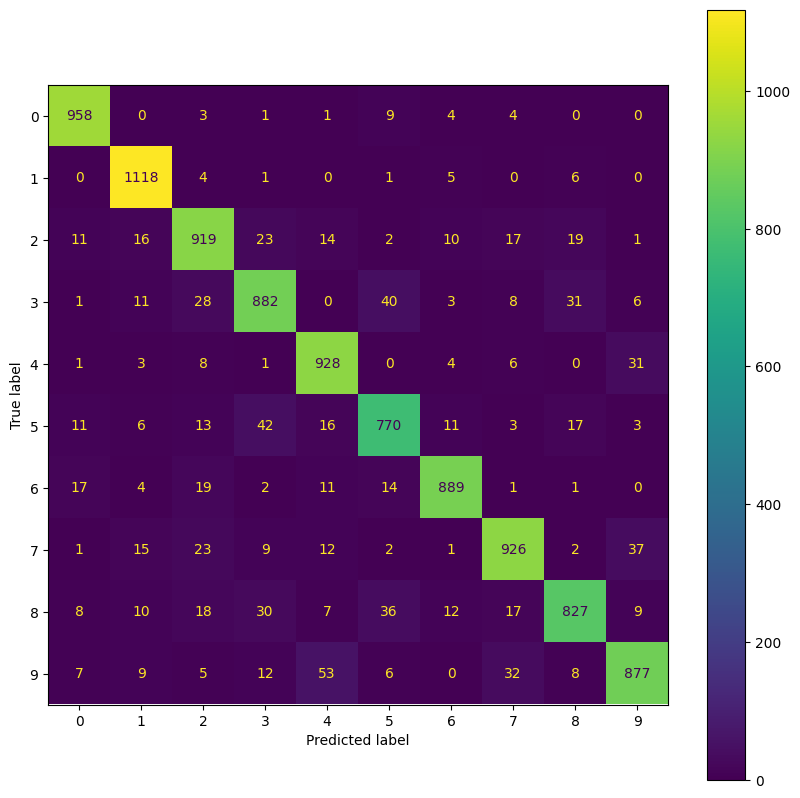

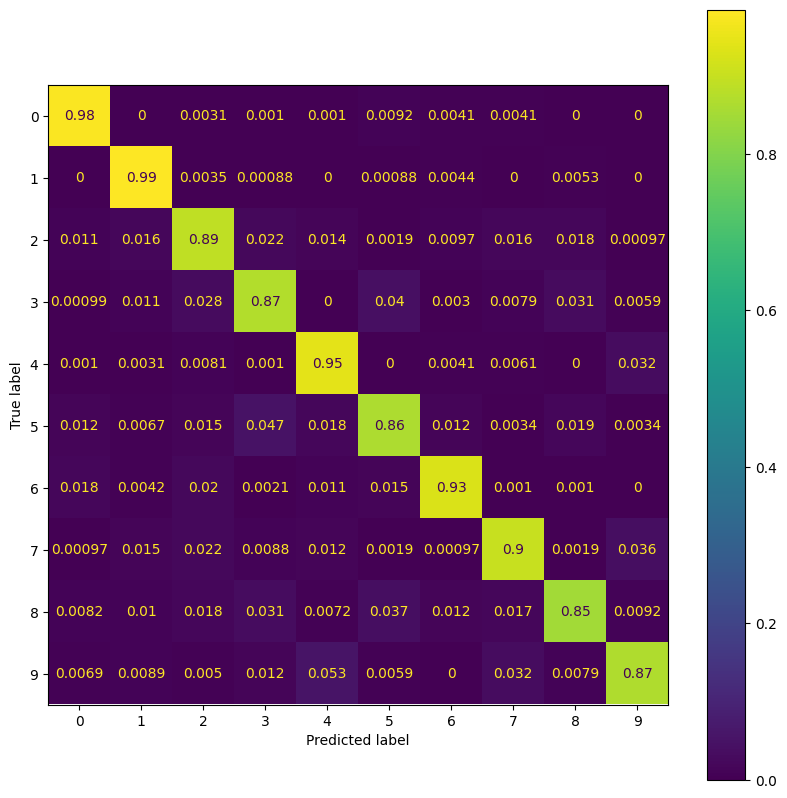

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
display = ConfusionMatrixDisplay.from_estimator(clf_SVML, Xtest, Ytest)
plt.close()  # close the 1st small figure generated by ConfusionMatrixDisplay
display.plot(ax=ax)

fig, ax = plt.subplots(figsize=(10, 10))
display = ConfusionMatrixDisplay.from_estimator(clf_SVML, Xtest, Ytest, normalize='true')
plt.close()
display.plot(ax=ax)

Confusion matrix, without normalization
[[ 958    0    3    1    1    9    4    4    0    0]
 [   0 1118    4    1    0    1    5    0    6    0]
 [  11   16  919   23   14    2   10   17   19    1]
 [   1   11   28  882    0   40    3    8   31    6]
 [   1    3    8    1  928    0    4    6    0   31]
 [  11    6   13   42   16  770   11    3   17    3]
 [  17    4   19    2   11   14  889    1    1    0]
 [   1   15   23    9   12    2    1  926    2   37]
 [   8   10   18   30    7   36   12   17  827    9]
 [   7    9    5   12   53    6    0   32    8  877]]
Normalized confusion matrix
[[9.8e-01 0.0e+00 3.1e-03 1.0e-03 1.0e-03 9.2e-03 4.1e-03 4.1e-03 0.0e+00
  0.0e+00]
 [0.0e+00 9.9e-01 3.5e-03 8.8e-04 0.0e+00 8.8e-04 4.4e-03 0.0e+00 5.3e-03
  0.0e+00]
 [1.1e-02 1.6e-02 8.9e-01 2.2e-02 1.4e-02 1.9e-03 9.7e-03 1.6e-02 1.8e-02
  9.7e-04]
 [9.9e-04 1.1e-02 2.8e-02 8.7e-01 0.0e+00 4.0e-02 3.0e-03 7.9e-03 3.1e-02
  5.9e-03]
 [1.0e-03 3.1e-03 8.1e-03 1.0e-03 9.5e-01 0.0e+00 4.1e-03 6.1

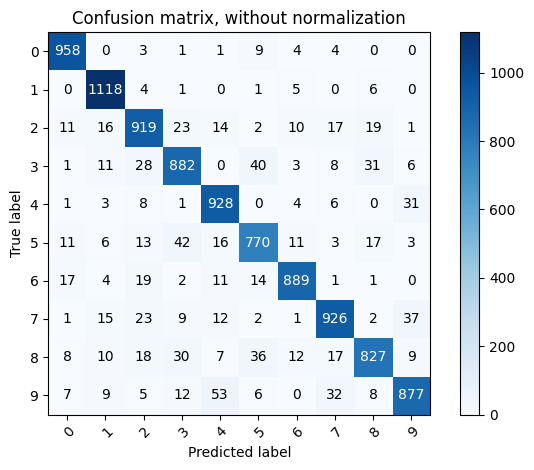

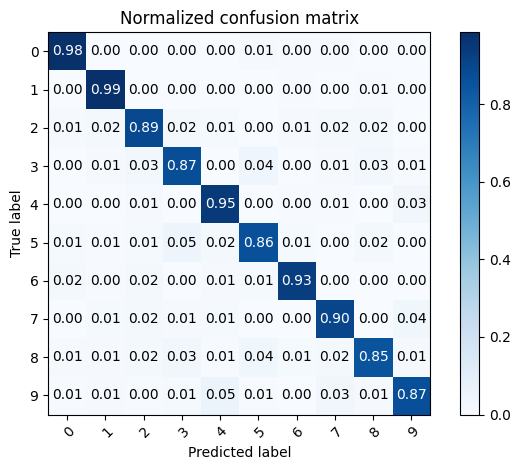

In [14]:
#For sklearn <0.22
digit_names=np.asarray(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
np.set_printoptions(precision=1)
plot_confusion_matrix(Ytest, Ytest_pred, classes = digit_names,title='Confusion matrix, without normalization')
plot_confusion_matrix(Ytest, Ytest_pred, classes=digit_names, normalize=True, title='Normalized confusion matrix')
plt.show()

*************************************
### Non linear SVM with rbf kernel
*************************************
#### List of hyperparameters:
- gamma : variance dans le noyau gaussien
- C : coefficient du coup, + C est grand , plus on veut pénaliser les erreurs

In [15]:
parameters = {'gamma':[0.001, 0.01, 0.1], 'C':[1, 10]} # oon va entrainer 3*2(nombre de combinaison d'hyperparametre) * 5 = 30 modeles
svc = svm.SVC(kernel="rbf")
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [16]:
clf_SVML = GridSearchCV(svc, parameters, cv=5)
clf_SVML.fit(Xtrain, Ytrain)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': [0.001, 0.01, 0.1]})

In [17]:
print(clf_SVML.best_score_) # correspond a acuracy = nombre_reponse_correcte/toute_les_reopnses
print(clf_SVML.best_estimator_.C)
clf_SVML.score(Xtest, Ytest)

0.9276
10


0.9384

In [18]:
Ytest_pred=clf_SVML.predict(Xtest)
print("Classification report for classifier %s:\n%s\n"
      % (clf_SVML, metrics.classification_report(Ytest, Ytest_pred)))

Classification report for classifier GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': [0.001, 0.01, 0.1]}):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.90      0.93      0.91      1032
           3       0.95      0.92      0.93      1010
           4       0.94      0.94      0.94       982
           5       0.94      0.92      0.93       892
           6       0.95      0.94      0.95       958
           7       0.90      0.94      0.92      1028
           8       0.94      0.91      0.92       974
           9       0.95      0.91      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000




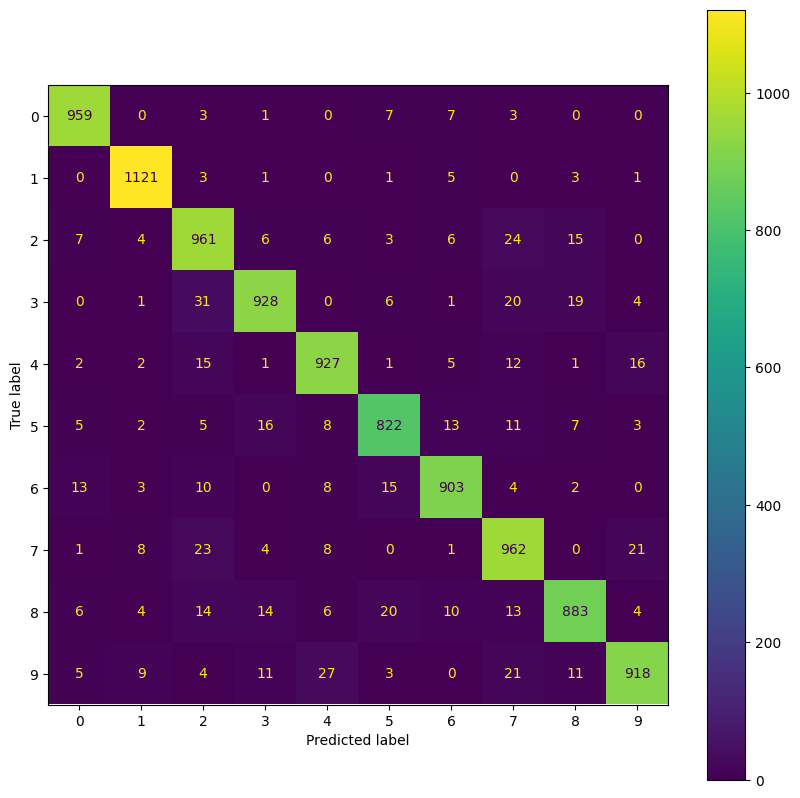

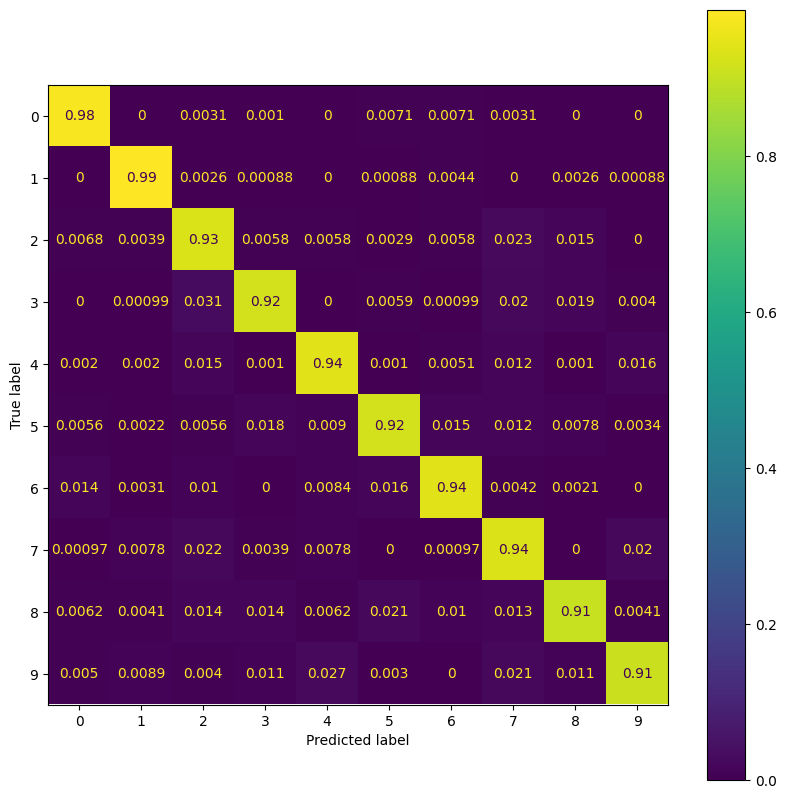

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
display = ConfusionMatrixDisplay.from_estimator(clf_SVML, Xtest, Ytest)
plt.close()  # close the 1st small figure generated by ConfusionMatrixDisplay
display.plot(ax=ax)

fig, ax = plt.subplots(figsize=(10, 10))
display = ConfusionMatrixDisplay.from_estimator(clf_SVML, Xtest, Ytest, normalize='true')
plt.close()
display.plot(ax=ax)

### A vous de jouer

*************************************
### Logistic regression
*************************************
#### List of hyperparameters:
- XX
- XX


### A vous de jouer

In [12]:
from sklearn.linear_model import LogisticRegression

In [24]:
parameters = {'C':[0.1, 1, 10, 100]} # oon va entrainer 4(nombre de combinaison d'hyperparametre) * 5 = 20 modeles

In [25]:
svc_reg = LogisticRegression(random_state=0)

clf_LR = GridSearchCV(svc_reg, parameters, cv=5)
clf_LR.fit(Xtrain, Ytrain)


c:\Users\gaell\OneDrive\Documents\5ETI\env_msi\env_msi\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\gaell\OneDrive\Documents\5ETI\env_msi\env_msi\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.1, 1, 10, 100]})

In [27]:
print(clf_LR.best_score_) # correspond a acuracy = nombre_reponse_correcte/toute_les_reopnses
print(clf_LR.best_estimator_.C)
clf_LR.score(Xtest, Ytest)

0.8939999999999999
0.1


0.8992

In [28]:
Ytest_pred=clf_LR.predict(Xtest)
print("Classification report for classifier %s:\n%s\n"
      % (clf_LR, metrics.classification_report(Ytest, Ytest_pred)))

Classification report for classifier GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.1, 1, 10, 100]}):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.94      0.97      0.95      1135
           2       0.88      0.85      0.87      1032
           3       0.88      0.86      0.87      1010
           4       0.90      0.93      0.91       982
           5       0.86      0.85      0.86       892
           6       0.92      0.92      0.92       958
           7       0.91      0.90      0.91      1028
           8       0.85      0.86      0.85       974
           9       0.90      0.88      0.89      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000




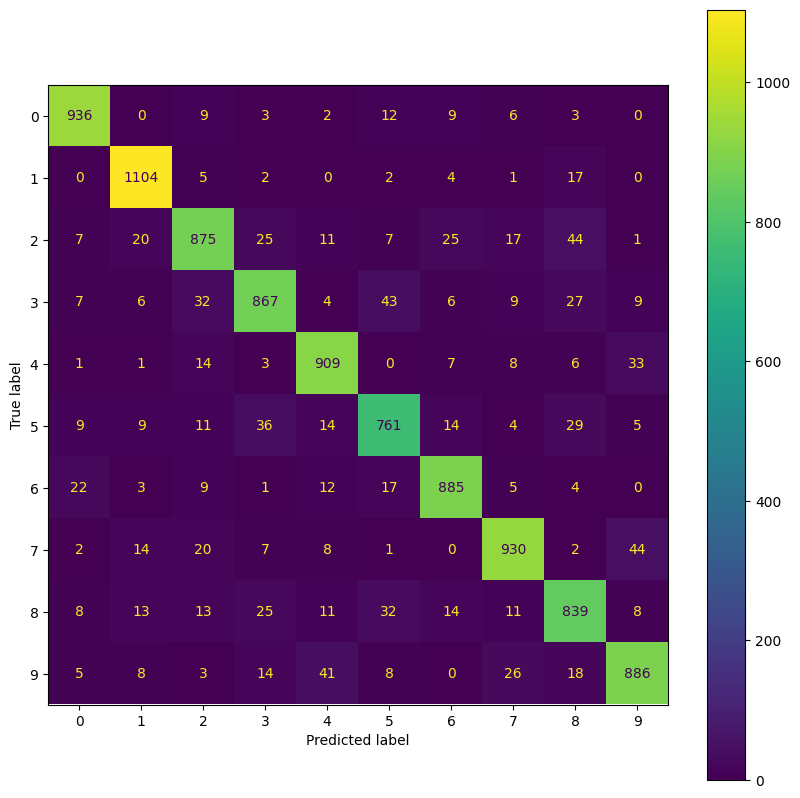

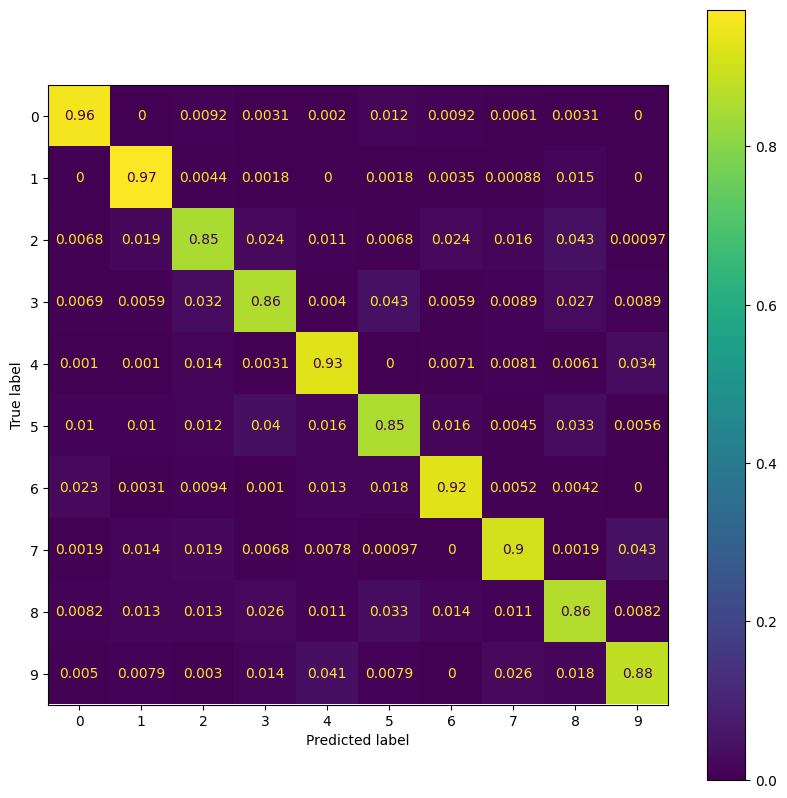

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
display = ConfusionMatrixDisplay.from_estimator(clf_LR, Xtest, Ytest)
plt.close()  # close the 1st small figure generated by ConfusionMatrixDisplay
display.plot(ax=ax)

fig, ax = plt.subplots(figsize=(10, 10))
display = ConfusionMatrixDisplay.from_estimator(clf_LR, Xtest, Ytest, normalize='true')
plt.close()
display.plot(ax=ax)

*************************************
### Decision tree (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
*************************************
#### List of hyperparameters:
- XX

In [30]:
# Decision Tree
from sklearn import tree

In [32]:
parameters = {'C':[0.1, 1, 10, 100],'max_depth':[5,10,15,20],'max_features' : [0.25,0.5,0.75,0.99]} 
parameters = {'max_features' : [0.25,0.5,0.75,0.99],'criterion' : ['entropy','gini']} 
svc_tree = tree.DecisionTreeClassifier(random_state=0)

clf_tree = GridSearchCV(svc_tree, parameters, cv=5)
clf_tree.fit(Xtrain, Ytrain)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_features': [0.25, 0.5, 0.75, 0.99]})

In [34]:
print(clf_tree.best_score_) # correspond a acuracy = nombre_reponse_correcte/toute_les_reopnses
clf_tree.score(Xtest, Ytest)

0.765


0.7811

In [35]:
Ytest_pred=clf_tree.predict(Xtest)
print("Classification report for classifier %s:\n%s\n"
      % (clf_LR, metrics.classification_report(Ytest, Ytest_pred)))

Classification report for classifier GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.1, 1, 10, 100]}):
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       980
           1       0.90      0.93      0.91      1135
           2       0.77      0.74      0.75      1032
           3       0.73      0.72      0.73      1010
           4       0.75      0.73      0.74       982
           5       0.70      0.65      0.68       892
           6       0.83      0.80      0.81       958
           7       0.80      0.80      0.80      1028
           8       0.74      0.72      0.73       974
           9       0.70      0.78      0.74      1009

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000




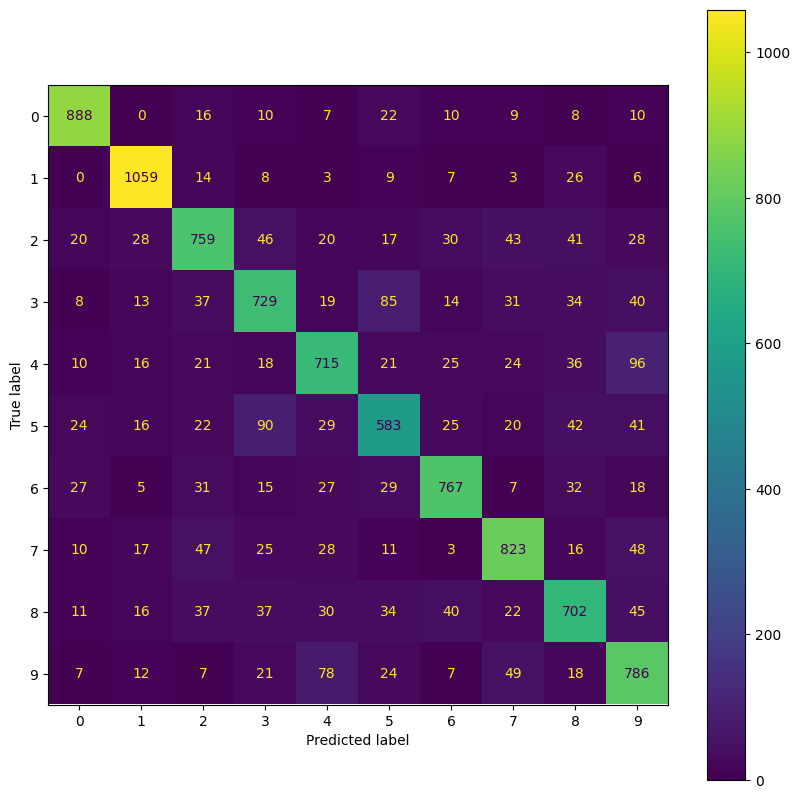

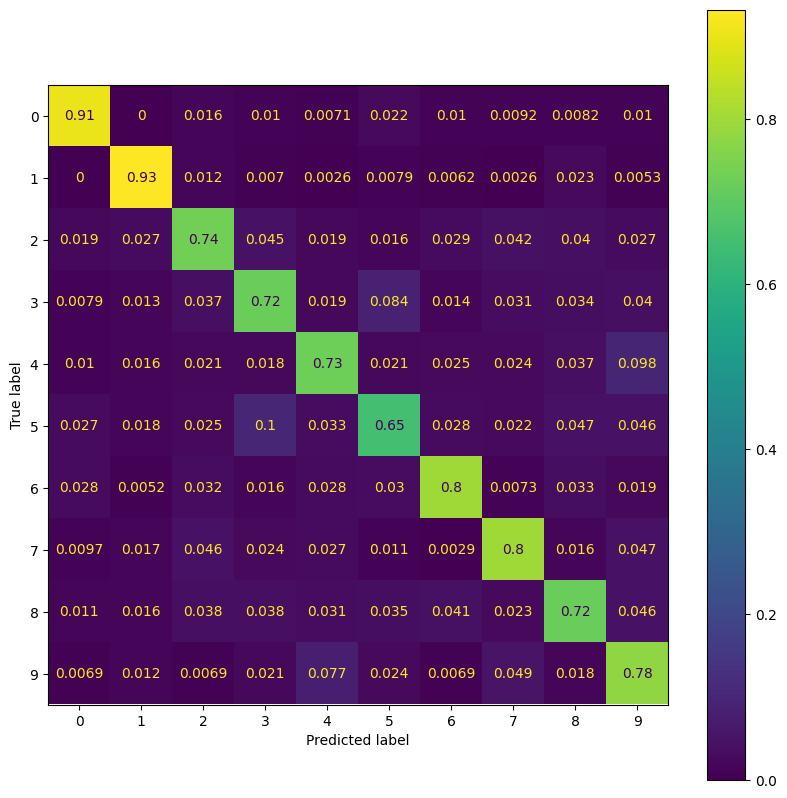

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
display = ConfusionMatrixDisplay.from_estimator(clf_tree, Xtest, Ytest)
plt.close()  # close the 1st small figure generated by ConfusionMatrixDisplay
display.plot(ax=ax)

fig, ax = plt.subplots(figsize=(10, 10))
display = ConfusionMatrixDisplay.from_estimator(clf_tree, Xtest, Ytest, normalize='true')
plt.close()
display.plot(ax=ax)

[Text(0.4711372985224983, 0.9666666666666667, 'x[406] <= -0.866\nentropy = 3.32\nsamples = 5000\nvalue = [512.0, 545.0, 502.0, 492.0, 454.0, 473.0, 491.0, 515.0\n474.0, 542.0]'),
 Text(0.22199252854264606, 0.9, 'x[436] <= -0.816\nentropy = 2.886\nsamples = 1945\nvalue = [505.0, 4.0, 185.0, 114.0, 180.0, 178.0, 183.0, 429.0\n32.0, 135.0]'),
 Text(0.3465649135325722, 0.9333333333333333, 'True  '),
 Text(0.12185191403626595, 0.8333333333333334, 'x[455] <= -0.459\nentropy = 2.252\nsamples = 940\nvalue = [479.0, 0.0, 47.0, 100.0, 15.0, 154.0, 46.0, 71.0, 10.0\n18.0]'),
 Text(0.07412693082605776, 0.7666666666666667, 'x[328] <= -0.64\nentropy = 2.645\nsamples = 436\nvalue = [68.0, 0.0, 30.0, 93.0, 5.0, 127.0, 37.0, 62.0, 8.0\n6.0]'),
 Text(0.039623908663532575, 0.7, 'x[458] <= -0.76\nentropy = 2.274\nsamples = 264\nvalue = [12, 0, 18, 76, 4, 107, 34, 4, 6, 3]'),
 Text(0.02182672934855608, 0.6333333333333333, 'x[351] <= -0.817\nentropy = 1.672\nsamples = 157\nvalue = [4, 0, 5, 75, 0, 64, 2, 4,

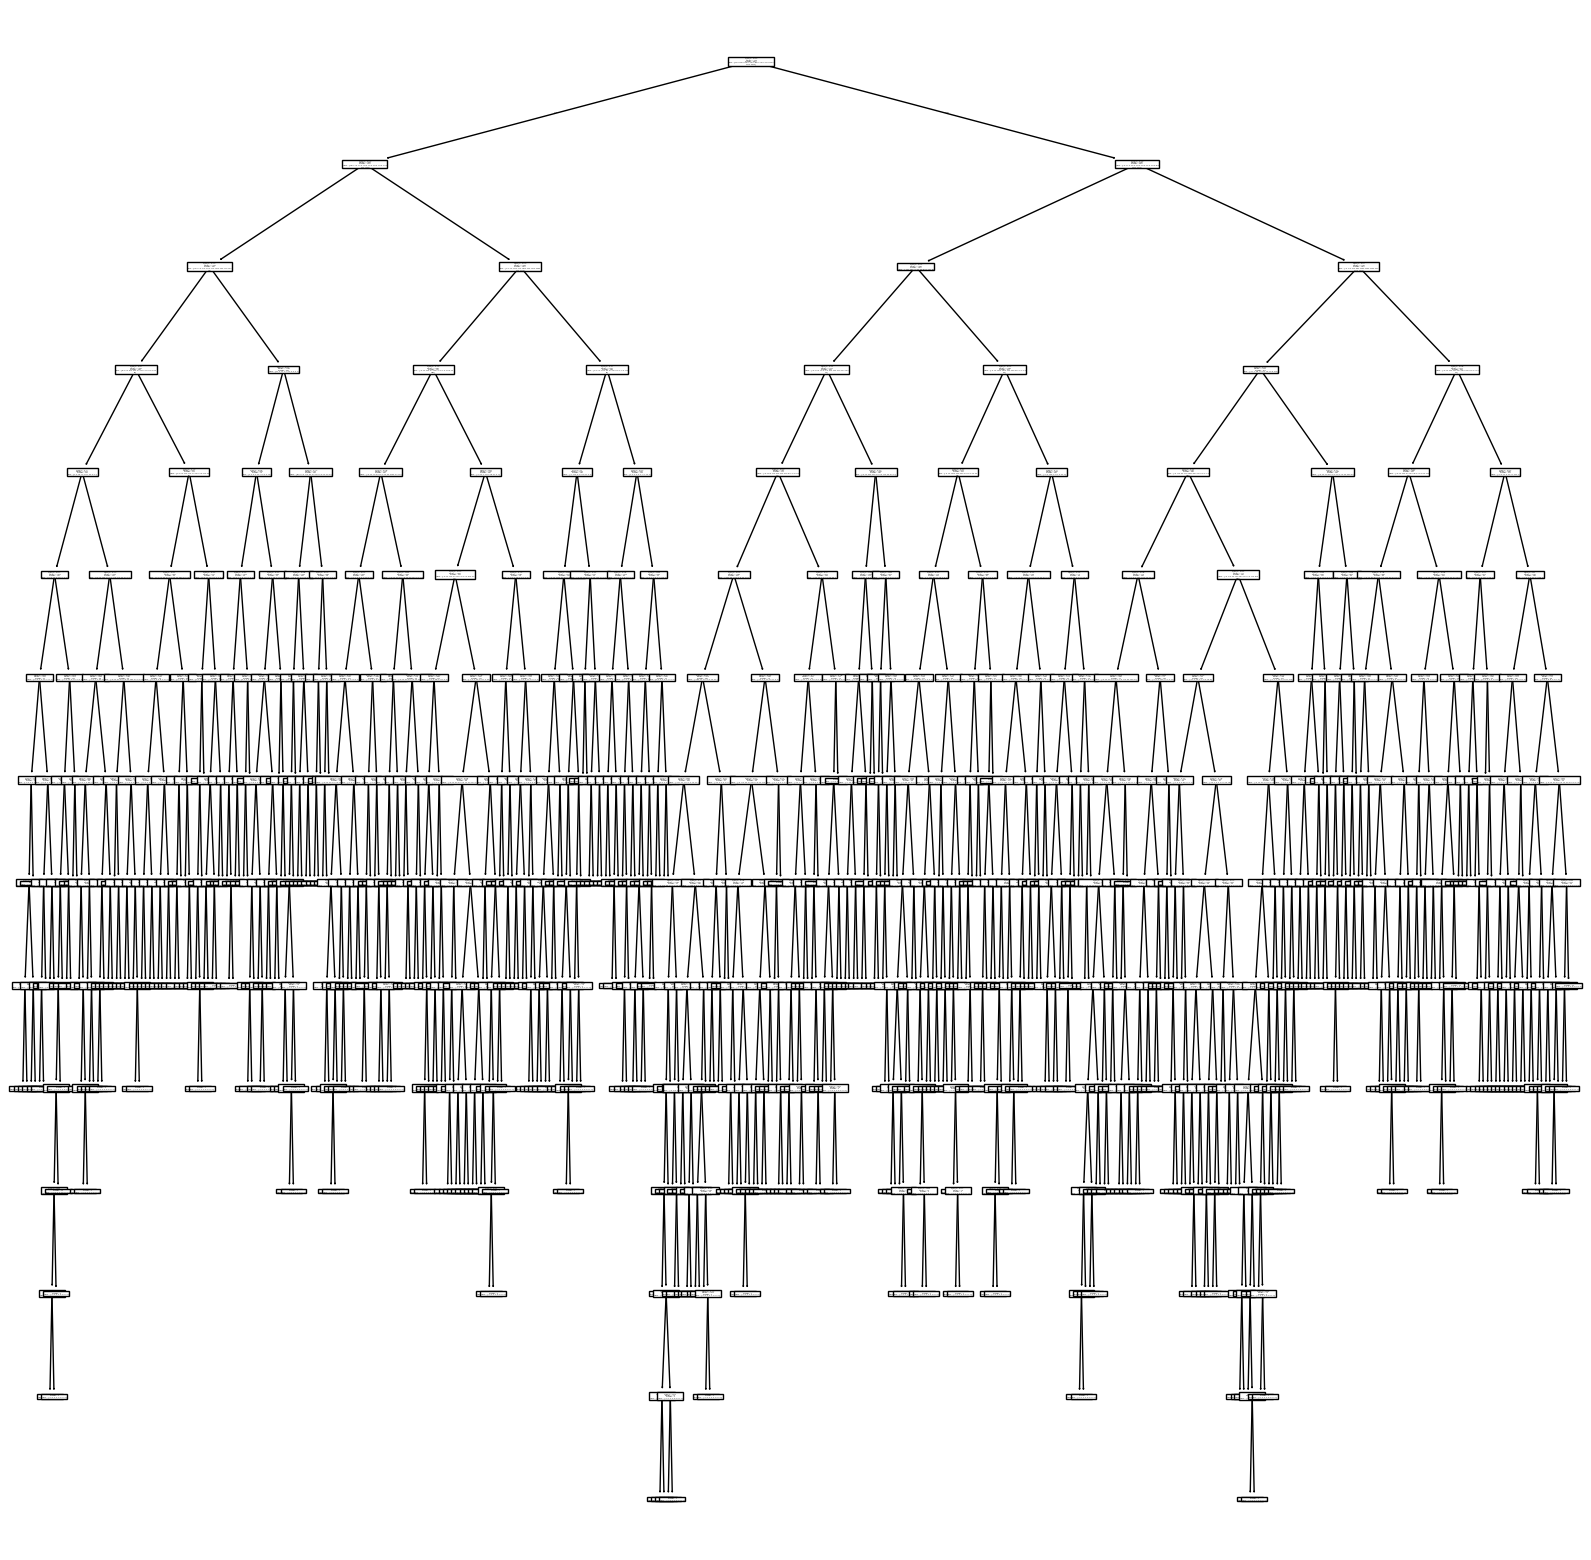

In [37]:
plt.figure(figsize=(20, 20))
tree.plot_tree(clf_tree.best_estimator_)

dans chaque boite de l'image on a la feature (le pixel sur lequel on a coupe en 2, feature la plus pertinante) avec le criterion utilise, le max_feature utilise

*************************************
### Random forest (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
*************************************
#### List of hyperparameters:
- n_estimators= Number of trees
- criterion{“gini”, “entropy”}, default=”gini”
- splitter{“best”, “random”}, default=”best”
- max_depthint, default=None
- min_samples_splitint or float, default=2
- max_features

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
parameters = {'n_estimators' :[10,50,100],'criterion' : ['gini','entropy'],'max_features' : [0.25,0.5,0.75,1]} 
svc_rf = RandomForestClassifier(random_state=0)

clf_rf = GridSearchCV(svc_rf, parameters, cv=5)
clf_rf.fit(Xtrain, Ytrain)

KeyboardInterrupt: 

*************************************
### Neural network - perceptron
*************************************
#### List of hyperparameters:
-   mlp = MLPClassifier(
    hidden_layer_sizes=(40,),
    max_iter=8,
    alpha=1e-4,
    solver="sgd",
    verbose=10,
    random_state=1,
    learning_rate_init=0.2,
- XX


In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
parameters = {'max_iter':[10, 100]}
MLP=MLPClassifier(random_state=1, hidden_layer_sizes=(40,30))
MLP.get_params()

## Feature extraction (optional)

Extract other feature types from the original MNIST data, eg
HOG features (see https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html)

Estimate the best performance achieved with this new feature set. How does it compare to the performance achieved with the original grey level features?

https://github.com/OSSpk/Handwritten-Digits-Classification-Using-KNN-Multiclass_Perceptron-SVM/blob/master/Code/multiclass_classification.py

8
(28, 28)
(112, 112)


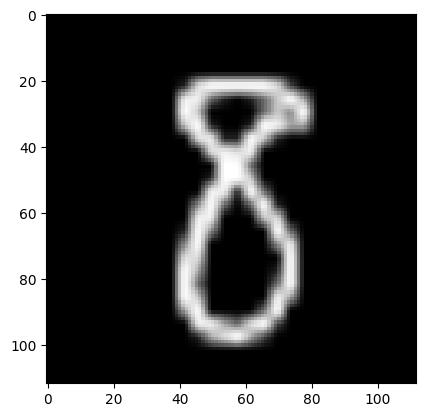

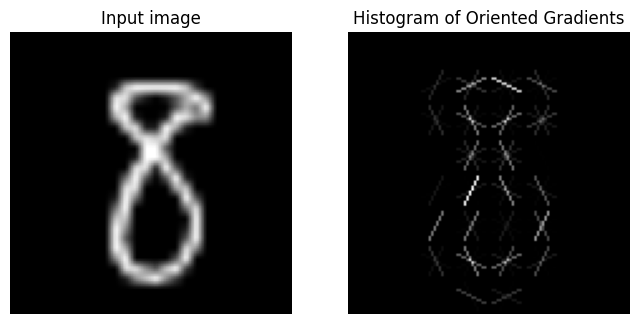

In [7]:
from skimage.feature import hog
from skimage import data, exposure
from skimage.transform import rescale, resize, downscale_local_mean

ind_img=11450
im=X[ind_img]
print(Y[ind_img])
im = im.reshape((28,28))
print(im.shape)

im_res=resize(im,(112,112), anti_aliasing=True)
image = im_res

print(image.shape)
plt.imshow(image, cmap="Greys_r")

fd, hog_image = hog(image, orientations=4, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=True)
fd.shape

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [8]:
X_hog=np.zeros((X.shape[0],256))
toto=np.zeros(256)
for k in range (0, 100):
#for k in range (0, X.shape[0]):
    im=X[k]
    im = im.reshape((28,28))
    im_res=resize(im,(112,112), anti_aliasing=True)
    fd, hog_image = hog(im_res, orientations=4, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=True)
    X_hog[k,:]=fd[:]

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:

ind_train=np.random.choice(np.arange(60000)+1, 5000, replace = False)

print(f"Nombres d'indices selectionnés : {ind_train.shape}")
print(f"Indice maximum : {max(ind_train)}")
print(f"indice minimum : {min(ind_train)}")

Xtrain=X_hog[ind_train]
print(f"Nouvelle forme Xtrain : {Xtrain.shape}")

Ytrain=Y[ind_train]
print(f"Nouvelle forme Ytrain : {Ytrain.shape}")


sum_ = 0
print(f"Valeur max Ytrain : {max(Ytrain)}")
print(f"Valeur min Ytrain : {min(Ytrain)}")
for k in range(0, 10):
    print(f"Nombre d'images d'entrainement de label {k} : {(Ytrain == k).sum()}")
    sum_ += ((Ytrain == k).sum())
print(f"Nombre total d'images d'entrainement: {sum_}")

#Construction de la base de test : 10000 derniers exemples de MNIST
sum_ = 0
Xtest = X_hog[60000:]
Ytest = Y[60000:]

for k in range(0, 10):
    print(f"Nombre d'images de test de label {k}: {(Ytest == k).sum()}")
    sum_ += ((Ytest == k).sum())
print(f"Nombre total d'images de test : {sum_}")

Nombres d'indices selectionnés : (5000,)
Indice maximum : 59992
indice minimum : 7
Nouvelle forme Xtrain : (5000, 256)
Nouvelle forme Ytrain : (5000,)
Valeur max Ytrain : 9
Valeur min Ytrain : 0
Nombre d'images d'entrainement de label 0 : 490
Nombre d'images d'entrainement de label 1 : 544
Nombre d'images d'entrainement de label 2 : 504
Nombre d'images d'entrainement de label 3 : 514
Nombre d'images d'entrainement de label 4 : 462
Nombre d'images d'entrainement de label 5 : 436
Nombre d'images d'entrainement de label 6 : 489
Nombre d'images d'entrainement de label 7 : 524
Nombre d'images d'entrainement de label 8 : 522
Nombre d'images d'entrainement de label 9 : 515
Nombre total d'images d'entrainement: 5000
Nombre d'images de test de label 0: 980
Nombre d'images de test de label 1: 1135
Nombre d'images de test de label 2: 1032
Nombre d'images de test de label 3: 1010
Nombre d'images de test de label 4: 982
Nombre d'images de test de label 5: 892
Nombre d'images de test de label 6: 958

In [15]:
sc = StandardScaler().fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

In [21]:
parameters = {'C':[0.1, 1, 10, 100]}
svc_reg = LogisticRegression(random_state=0)

clf_LR = GridSearchCV(svc_reg, parameters, cv=5)
print(Xtrain.shape)
print(Ytrain.shape)
clf_LR.fit(Xtrain, Ytrain)

(5000, 256)
(5000,)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100]})

In [22]:
print(clf_LR.best_score_) # correspond a acuracy = nombre_reponse_correcte/toute_les_reopnses
clf_LR.score(Xtest, Ytest)

0.1092


0.1135

In [60]:
Ytest_pred=clf_LR.predict(Xtest)
print("Classification report for classifier %s:\n%s\n"
      % (clf_LR, metrics.classification_report(Ytest, Ytest_pred)))

Classification report for classifier GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.1, 1, 10, 100]}):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.11      1.00      0.20      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.11     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.11      0.02     10000




c:\Users\gaell\OneDrive\Documents\5ETI\env_msi\env_msi\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gaell\OneDrive\Documents\5ETI\env_msi\env_msi\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gaell\OneDrive\Documents\5ETI\env_msi\env_msi\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

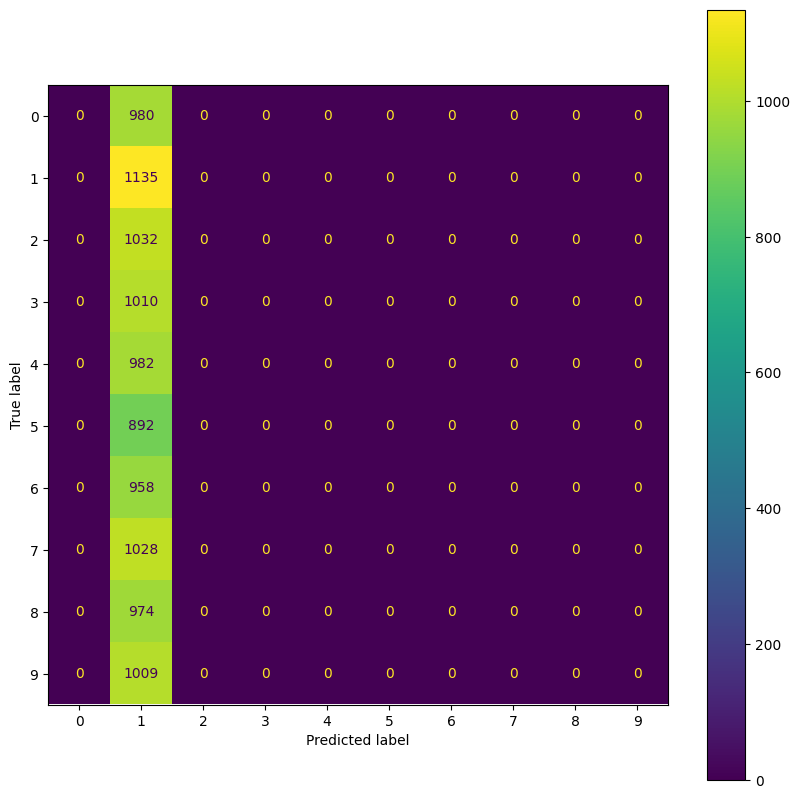

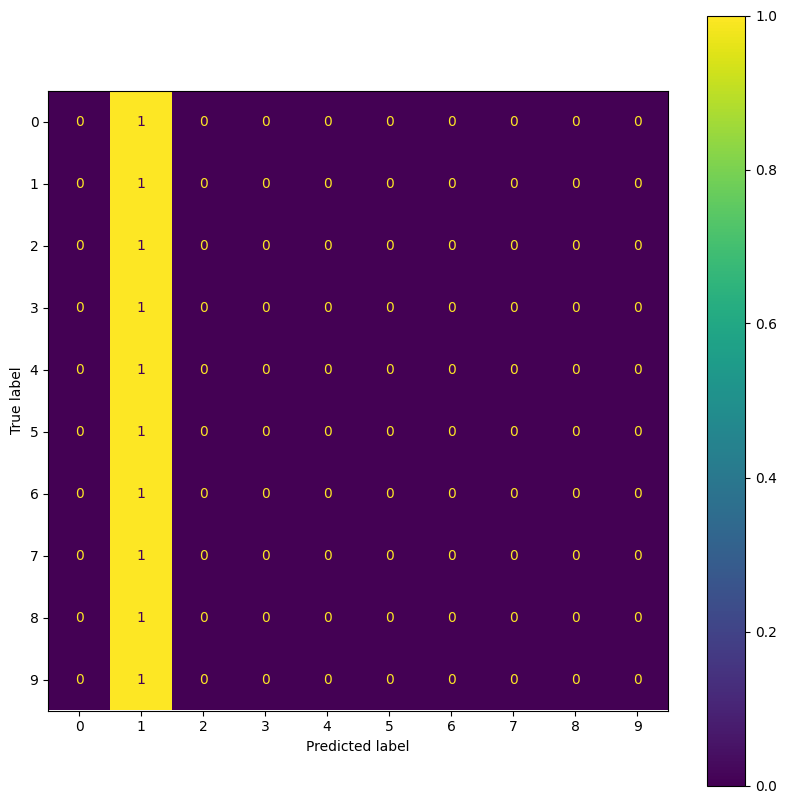

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))
display = ConfusionMatrixDisplay.from_estimator(clf_LR, Xtest, Ytest)
plt.close()  # close the 1st small figure generated by ConfusionMatrixDisplay
display.plot(ax=ax)

fig, ax = plt.subplots(figsize=(10, 10))
display = ConfusionMatrixDisplay.from_estimator(clf_LR, Xtest, Ytest, normalize='true')
plt.close()
display.plot(ax=ax)